In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importing Libaries

In [ ]:
# Import libraries
import os
import cv2
import torch
import torch.nn as nn
import torchvision
import albumentations as A
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import shutil
import random
from collections import defaultdict
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import os
import shutil
import re
import os
import torch
import numpy as np
from PIL import Image
import math
from typing import List, Tuple
import torch
import torch.nn.functional as F
from torch.nn.utils import spectral_norm as SN
from torchvision import transforms
from torchvision import models, datasets
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from pathlib import Path
# !pip install facenet_pytorch
# Downgrade pytorch to avoid Error: module 'torch' has no attribute 'unit64'
# !pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 -f https://download.pytorch.org/whl/torch_stable.html
from facenet_pytorch import InceptionResnetV1
from sklearn.metrics.pairwise import cosine_similarity

### Loading dataset

In [ ]:
class LOLDataset(Dataset):
    def __init__(self, low_dir, high_dir, transform=None):
        self.low_paths = sorted(glob.glob(os.path.join(low_dir, "*.png")))
        self.high_paths = sorted(glob.glob(os.path.join(high_dir, "*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.low_paths)

    def __getitem__(self, idx):
        low = Image.open(self.low_paths[idx]).convert("RGB")
        high = Image.open(self.high_paths[idx]).convert("RGB")
        if self.transform:
            low = self.transform(low)
            high = self.transform(high)
        return low, high

### GAN Enhancer

##### Experiment 1

In [ ]:
# Attention block
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attn = self.sigmoid(self.conv(x))
        return x * attn

# ConvBlock used in UNet
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

In [ ]:
# UNet Generator with Attention
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()
        self.enc1 = ConvBlock(in_channels, 64)
        self.attn1 = AttentionBlock(64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128)
        self.attn2 = AttentionBlock(128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256)
        self.attn3 = AttentionBlock(256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.attn1(self.enc1(x))
        e2 = self.attn2(self.enc2(self.pool1(e1)))
        e3 = self.attn3(self.enc3(self.pool2(e2)))
        b = self.bottleneck(self.pool3(e3))
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return torch.sigmoid(self.final(d1))

In [ ]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels * 2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, low, high):
        x = torch.cat([low, high], dim=1)
        return self.model(x)

# PSNR and SSIM calculation
def compute_metrics(output, target):
    output_np = output.detach().permute(1, 2, 0).cpu().numpy()
    target_np = target.detach().permute(1, 2, 0).cpu().numpy()
    psnr = peak_signal_noise_ratio(target_np, output_np, data_range=1.0)
    ssim = structural_similarity(target_np, output_np, win_size=3, channel_axis=2, data_range=1.0)
    return psnr, ssim

### Training experiment 1 GAN

In [ ]:
# Visualization
def visualize_enhancement(model, dataset, epoch, save_dir="/content/drive/MyDrive/Dissertation/enhancement_per_epoch", num_samples=3, show=False):

    '''Visualize enhancement results and save the viasualizations to save_dir'''

    os.makedirs(save_dir, exist_ok=True)  # Create folder if it doesn't exist
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            low, high = dataset[i]
            input_tensor = low.unsqueeze(0).to(device)
            output = model(input_tensor).squeeze(0).cpu()

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(low.permute(1, 2, 0))
            axs[0].set_title("Low Light")
            axs[1].imshow(high.permute(1, 2, 0))
            axs[1].set_title("Ground Truth")
            axs[2].imshow(output.permute(1, 2, 0))
            axs[2].set_title("Enhanced")

            for ax in axs:
                ax.axis("off")

            # Save plot
            save_path = os.path.join(save_dir, f"epoch_{epoch+1}_sample_{i+1}.png")
            plt.savefig(save_path, bbox_inches="tight")

            # Show plot only if requested
            if show:
                plt.show()

            plt.close(fig)  # Always close to free memory


In [ ]:
def evaluate_on_eval15_and_log(generator, eval_loader, epoch, training_performance,
                                save_dir="/content/drive/MyDrive/Dissertation/evaluation2/enhancement_per_epoch",
                                performance_csv="/content/drive/MyDrive/Dissertation/evaluation2/training_performance.csv"):

  '''Evaluate generator performance on LOL evaluation Dataset'''
  generator.eval()
  os.makedirs(save_dir, exist_ok=True)

  total_psnr = 0.0
  total_ssim = 0.0
  count = 0

  with torch.no_grad():
      for i, (low, high) in enumerate(eval_loader):
          low = low.to(device)
          high = high.to(device)

          enhanced = generator(low)

          # Save enhanced image (low | enhanced | ground truth)
          result = torch.cat([low.cpu(), enhanced.cpu(), high.cpu()], dim=0)
          save_path = os.path.join(save_dir, f"epoch_{epoch+1}_eval15_sample_{i+1}.png")
          save_image(result, save_path, nrow=3, normalize=True)

          # Compute PSNR and SSIM
          psnr, ssim = compute_metrics(enhanced.squeeze(0), high.squeeze(0))
          total_psnr += psnr
          total_ssim += ssim
          count += 1

  avg_psnr = total_psnr / count
  avg_ssim = total_ssim / count
  print(f"Eval15 — Epoch {epoch+1}: PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

  # Add to DataFrame
  training_performance.loc[epoch, "eval_psnr"] = avg_psnr
  training_performance.loc[epoch, "eval_ssim"] = avg_ssim

  # Save to disk
  training_performance.to_csv(performance_csv, index=False)

  return training_performance

In [ ]:
# Training configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8
epochs = 60
checkpoint_dir = "/content/drive/MyDrive/Dissertation/checkpoints/gan/"
os.makedirs(checkpoint_dir, exist_ok=True)

# Transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Dataset and DataLoader
base_path = "/content/drive/MyDrive/Dissertation/data/LOL_dataset"

# Our485 for training
train_dataset = LOLDataset(
    low_dir=os.path.join(base_path, "our485/low"),
    high_dir=os.path.join(base_path, "our485/high"),
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Eval15 for evaluation
eval_dataset = LOLDataset(
    low_dir=os.path.join(base_path, "eval15/low"),
    high_dir=os.path.join(base_path, "eval15/high"),
    transform=transform
)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

# dataset = LOLDataset("/content/drive/MyDrive/Dissertation/data/LOL_dataset", transform=transform)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Models
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)

# Losses and Optimizers
mse_loss = nn.MSELoss()
bce_loss = nn.BCEWithLogitsLoss()
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

# Load checkpoint if exists
start_epoch = 0
checkpoint_path = os.path.join(checkpoint_dir, "gan_epoch_.pth") # Add the latest or desired checkpoint
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    g_optimizer.load_state_dict(checkpoint["g_optimizer_state_dict"])
    d_optimizer.load_state_dict(checkpoint["d_optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed from epoch {start_epoch}")


# Record training perfomance per epoch
training_performance = pd.DataFrame(columns=["epoch", "g_loss", "d_loss", "train_psnr", "eval_psnr","train_ssim", "eval_ssim"])

# Training loop
for epoch in range(start_epoch, epochs):
    generator.train()
    discriminator.train()
    g_running_loss = 0.0
    d_running_loss = 0.0
    psnr_total = 0.0
    ssim_total = 0.0

    for low, high in train_loader:
        low, high = low.to(device), high.to(device)

        # Train Discriminator
        d_optimizer.zero_grad()
        real_output = discriminator(low, high)
        fake_high = generator(low)
        fake_output = discriminator(low, fake_high.detach())
        real_labels = torch.ones_like(real_output)
        fake_labels = torch.zeros_like(fake_output)
        d_loss = bce_loss(real_output, real_labels) + bce_loss(fake_output, fake_labels)
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        fake_high = generator(low)
        adv_output = discriminator(low, fake_high)
        adv_loss = bce_loss(adv_output, real_labels)
        recon_loss = mse_loss(fake_high, high)
        g_loss = recon_loss + 0.01 * adv_loss
        g_loss.backward()
        g_optimizer.step()

        g_running_loss += g_loss.item() * low.size(0)
        d_running_loss += d_loss.item() * low.size(0)

        # Compute PSNR and SSIM for one sample in batch
        psnr, ssim = compute_metrics(fake_high[0], high[0])
        psnr_total += psnr
        ssim_total += ssim

    g_epoch_loss = g_running_loss / len(train_dataset)
    d_epoch_loss = d_running_loss / len(train_dataset)
    avg_psnr = psnr_total / len(train_loader)
    avg_ssim = ssim_total / len(train_loader)

    # save perfromance
    training_performance.loc[epoch] = [epoch+1, g_epoch_loss, d_epoch_loss, avg_psnr, None, avg_ssim, None]

    # Evaluation
    training_performance = evaluate_on_eval15_and_log(generator, eval_loader, epoch, training_performance)
    eval_psnr = training_performance.loc[epoch, "eval_psnr"]
    eval_ssim = training_performance.loc[epoch, "eval_ssim"]

    print(f"Epoch {epoch+1}/{epochs}, G Loss: {g_epoch_loss:.4f}, D Loss: {d_epoch_loss:.4f}, train PSNR: {avg_psnr:.2f}, eval psnr: {eval_psnr}, train SSIM: {avg_ssim:.4f}, eval ssim: {eval_ssim}")

    # Save checkpoint
    torch.save({
        "epoch": epoch,
        "generator_state_dict": generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "g_optimizer_state_dict": g_optimizer.state_dict(),
        "d_optimizer_state_dict": d_optimizer.state_dict()
    }, os.path.join(checkpoint_dir, f"gan_epoch_{epoch+1}.pth"))



    # Save/Visualize after each epoch
    # print(f"Visualizing results for Epoch {epoch+1}...")

    # visualize_enhancement(generator, dataset, epoch=epoch+1, num_samples=3)

In [ ]:
training_performance

,epoch,g_loss,d_loss,train_psnr,eval_psnr,train_ssim,eval_ssim
0,1.0,0.396613,0.578092,5.352975,4.845356,0.000832,-0.020766
1,2.0,0.347837,0.086328,6.474161,5.606062,0.039903,-0.010724
2,3.0,0.334174,0.030033,6.472020,5.833778,0.027986,0.001447
3,4.0,0.323443,0.017352,6.448344,6.179128,-0.023750,-0.000177
4,5.0,0.311026,0.011240,6.065579,6.391279,-0.053892,0.015480
5,6.0,0.301230,0.007632,5.933507,6.540877,-0.059164,0.028762
6,7.0,0.294127,0.005702,6.453319,6.912491,-0.036084,0.021496
7,8.0,0.286091,0.004508,7.167303,7.048955,-0.017797,0.043084
8,9.0,0.278362,0.003625,6.785687,6.870243,0.005784,0.026997
9,10.0,0.275695,0.003053,7.850964,7.453910,0.052956,0.059745


#### ExDark

In [ ]:
# Set paths
exdark_path = "/content/drive/MyDrive/Dissertation/data/ExDark"
enhanced_path = "/content/drive/MyDrive/Dissertation/data/ExDark_enhanced"
os.makedirs(enhanced_path, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# For reversing normalization when saving
inv_normalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)

In [ ]:
# Load best model from GAN trainig
generator = UNetGenerator().to(device)
checkpoint_path = "/content/drive/MyDrive/Dissertation/checkpoints/gan/gan_epoch_60.pth" # Best model saved from GAN training

checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

#### Enhancing ExDark Images with experiment 1

In [ ]:
for class_name in tqdm(os.listdir(exdark_path), desc="Enhancing ExDark"):
    class_dir = os.path.join(exdark_path, class_name)
    save_dir = os.path.join(enhanced_path, class_name)
    os.makedirs(save_dir, exist_ok=True)

    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)

        try:
            img = Image.open(img_path).convert("RGB")
        except:
            continue

        input_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            enhanced = generator(input_tensor).squeeze(0).cpu()
            enhanced = inv_normalize(enhanced).clamp(0, 1)

        save_image(enhanced, os.path.join(save_dir, img_name))

#### Preparing data for RestNet

In [ ]:
def create_shared_splits(orig_path, enh_path, output_root_orig, output_root_enh,
                         train_ratio=0.7, val_ratio=0.15):
    """Creates shared train, validation, and test splits for original and enhanced images.

    Ensures that the same set of images for each class goes into the corresponding
    split (train, val, test) for both the original and enhanced datasets.
    e.g for every corresponding image in bicycle class in train split, there is a corresponding
    enhanced bicycle image in the ehanced train split.

    """

    output_root_orig = Path(output_root_orig)
    output_root_enh = Path(output_root_enh)

    # Reset directories
    for root in [output_root_orig, output_root_enh]:
        if root.exists():
            shutil.rmtree(root)

    classes = [d for d in os.listdir(orig_path) if os.path.isdir(os.path.join(orig_path, d))]

    for split in ['train', 'val', 'test']:
        for cls in classes:
            (output_root_orig / split / cls).mkdir(parents=True, exist_ok=True)
            (output_root_enh / split / cls).mkdir(parents=True, exist_ok=True)

    for cls in classes:
        orig_cls_dir = Path(orig_path) / cls
        enh_cls_dir = Path(enh_path) / cls
        images = list(orig_cls_dir.glob('*'))
        random.shuffle(images)
        n = len(images)
        train_end = int(train_ratio * n)
        val_end = int((train_ratio + val_ratio) * n)

        # Function to copy paired files
        def copy_pair(indices, split):
            for img in indices:
                orig_img = img
                enh_img = enh_cls_dir / img.name
                if not enh_img.exists():
                    continue  # Skip if no enhanced version
                shutil.copy(orig_img, output_root_orig / split / cls / img.name)
                shutil.copy(enh_img, output_root_enh / split / cls / img.name)

        copy_pair(images[:train_end], 'train')
        copy_pair(images[train_end:val_end], 'val')
        copy_pair(images[val_end:], 'test')

# Now call it ONCE
create_shared_splits(
    orig_path='/content/drive/MyDrive/Dissertation/data/ExDark',
    enh_path='/content/drive/MyDrive/Dissertation/data/ExDark_enhanced',
    output_root_orig='/content/drive/MyDrive/Dissertation/data/ExDark_split',
    output_root_enh='/content/drive/MyDrive/Dissertation/data/ExDark_enhanced_split'
)

In [ ]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Paths for the split datasets
orig_split = '/content/drive/MyDrive/Dissertation/data/ExDark_split'
enh_split = '/content/drive/MyDrive/Dissertation/data/ExDark_enhanced_split'

# Data Loaders
weights = ResNet18_Weights.DEFAULT
data_transforms = weights.transforms()

def get_loaders(base_path, batch_size=32):
    image_datasets = {
        split: datasets.ImageFolder(os.path.join(base_path, split),
                                    transform=data_transforms)
        for split in ['train', 'val', 'test']
    }
    dataloaders = {
        split: DataLoader(image_datasets[split], batch_size=batch_size,
                          shuffle=(split == 'train'), num_workers=2)
        for split in ['train', 'val', 'test']
    }
    return dataloaders, image_datasets['train'].classes

orig_loaders, class_names = get_loaders(orig_split)
enh_loaders, _ = get_loaders(enh_split)

# Model Setup
model = models.resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, len(class_names))  # Match ExDark class count
model = model.to(device)

# Freeze all layers except the classification head
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

#### Re-Training and testing RestNet model on enhanced Images

In [ ]:
#Training and Validation
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

def train_model(model, loaders, epochs=10):
    best_acc = 0.0
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        model.train()
        running_loss, correct, total = 0, 0, 0

        for inputs, labels in loaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, loaders['val'])
        print(f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Save the best model based on validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_resnet18.pth')
    print(f'Best Val Accuracy: {best_acc:.4f}')

train_model(model, orig_loaders, epochs=10)

# Testing RestNet on Original vs Enhanced
def test_and_report(model, loader, label='Dataset'):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f'\n--- {label} ---')
    print(f'Accuracy: {acc:.4f}')
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f'{label} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return acc, all_preds, all_labels

# Load best checkpoint
model.load_state_dict(torch.load('best_resnet18.pth'))

# Test on Original
orig_acc, orig_preds, orig_labels = test_and_report(model, orig_loaders['test'], 'Original Images')

# Test on Enhanced
enh_acc, enh_preds, enh_labels = test_and_report(model, enh_loaders['test'], 'Enhanced Images')

print(f'\nAccuracy Improvement (Enhanced vs Original): {enh_acc - orig_acc:.4f}')

#### Quantifying experiment 1 effect on the recognition task

In [ ]:
# Ensure the test datasets have the same file ordering for comparison
orig_dataset = orig_loaders['test'].dataset
enh_dataset = enh_loaders['test'].dataset
assert [p[0].split('/')[-1] for p in orig_dataset.samples] == \
       [p[0].split('/')[-1] for p in enh_dataset.samples], \
       "Original and Enhanced test datasets must have identical image order for comparison."

# Map predictions to filenames
filenames = [p[0].split('/')[-1] for p in orig_dataset.samples]
comparison_stats = defaultdict(int)  # counters

# Compare results image by image
for fname, true, pred_orig, pred_enh in zip(filenames, orig_labels, orig_preds, enh_preds):
    if pred_orig == true and pred_enh == true:
        comparison_stats['correct_both'] += 1
    elif pred_orig != true and pred_enh != true:
        comparison_stats['wrong_both'] += 1
    elif pred_orig != true and pred_enh == true:
        comparison_stats['fixed_by_enhancement'] += 1
    elif pred_orig == true and pred_enh != true:
        comparison_stats['harmed_by_enhancement'] += 1

# Print summary
total = len(filenames)
print("\n--- Per-Image Comparison ---")
for k, v in comparison_stats.items():
    print(f"{k}: {v} ({v/total:.2%})")
print(f"Total test samples: {total}")
print(f"Net improvement (fixed - harmed): {comparison_stats['fixed_by_enhancement'] - comparison_stats['harmed_by_enhancement']}")

#### Testing Experiment 1 on Scface

In [ ]:
# Re-organinzing scface data into Gallery(original images) and probe (images taken with 7 cameras) images, by camera and subject
# Paths
mugshot_path = "/content/drive/MyDrive/Dissertation/data/SCface_database/mugshot_frontal_original_all"
surveillance_path = "/content/drive/MyDrive/Dissertation/data/SCface_database/surveillance_cameras_all"
arranged_path = "/content/drive/MyDrive/Dissertation/data/SCface_database_arranged"

gallery_path = os.path.join(arranged_path, "SCface_gallery")
probe_base = os.path.join(arranged_path, "SCface_probe")

# Create directories
os.makedirs(gallery_path, exist_ok=True)
for d in [1, 2, 3]:
    os.makedirs(os.path.join(probe_base, f"probe_distance{d}"), exist_ok=True)

# Gallery (Original mugshots)
mugshot_files = [f for f in sorted(os.listdir(mugshot_path))
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

for fname in mugshot_files:
    sid = fname.split('_')[0]  # e.g., "001"
    subj_dir = os.path.join(gallery_path, f"s{sid}")
    os.makedirs(subj_dir, exist_ok=True)
    shutil.copy(os.path.join(mugshot_path, fname), os.path.join(subj_dir, fname))

print(f"✅ Copied {len(mugshot_files)} mugshots into gallery.")

# Probe (surveillance taken with different cameras at different distance)
surv_files = [f for f in sorted(os.listdir(surveillance_path))
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

counts = {1: 0, 2: 0, 3: 0, "unknown": 0}

for fname in surv_files:
    parts = Path(fname).stem.split('_')  # e.g., ['001', 'cam1', '1']
    if len(parts) != 3:
        counts["unknown"] += 1
        continue

    sid, cam, dist = parts
    try:
        dist = int(dist)
    except ValueError:
        counts["unknown"] += 1
        continue

    subj_dir = os.path.join(probe_base, f"probe_distance{dist}", f"s{sid}")
    os.makedirs(subj_dir, exist_ok=True)
    shutil.copy(os.path.join(surveillance_path, fname), os.path.join(subj_dir, fname))
    counts[dist] += 1

print("✅ Probe set created.")
print(f"Distance 1: {counts[1]} images")
print(f"Distance 2: {counts[2]} images")
print(f"Distance 3: {counts[3]} images")
print(f"Unknown format: {counts['unknown']} images")

#### Enhancing the images using experiment 1

In [ ]:
probe_base = "/content/drive/MyDrive/Dissertation/data/SCface_database_arranged/SCface_probe"
enhanced_base = "/content/drive/MyDrive/Dissertation/data/SCface_database_arranged/SCface_probe_enhanced"
os.makedirs(enhanced_base, exist_ok=True)

# Load Generator
generator = UNetGenerator().to(device)
checkpoint_path = "/content/drive/MyDrive/Dissertation/checkpoints/gan/gan_epoch_60.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint["generator_state_dict"])
generator.eval()
print("✅ Loaded trained GAN generator.")

# transfom
inv_normalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Enhancement Loop
for dist in [1, 2, 3]:
    probe_dist_dir = os.path.join(probe_base, f"probe_distance{dist}")
    enhanced_dist_dir = os.path.join(enhanced_base, f"probe_distance{dist}")
    os.makedirs(enhanced_dist_dir, exist_ok=True)

    for subject in sorted(os.listdir(probe_dist_dir)):
        subject_path = os.path.join(probe_dist_dir, subject)
        if not os.path.isdir(subject_path):
            continue

        enhanced_subject_path = os.path.join(enhanced_dist_dir, subject)
        os.makedirs(enhanced_subject_path, exist_ok=True)

        for img_name in sorted(os.listdir(subject_path)):
            if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
                continue

            img_path = os.path.join(subject_path, img_name)
            img = Image.open(img_path).convert("RGB")

            # Transform
            img_tensor = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                enhanced_tensor = generator(img_tensor)

            # Inverse normalization
            enhanced_tensor = inv_normalize(enhanced_tensor.squeeze(0).cpu()).clamp(0, 1)
            enhanced_img = transforms.ToPILImage()(enhanced_tensor)

            # Save enhanced image
            enhanced_img.save(os.path.join(enhanced_subject_path, img_name))

    print(f"✅ Enhanced images saved for probe_distance{dist}")

print("🎯 All probe distances enhanced and saved.")


#### Evaluating enhancement on SCface data using pretrained vggface2.

In [ ]:
# !pip install facenet_pytorch
# Downgrade pytorch to avoid Error: module 'torch' has no attribute 'unit64'
# !pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
base_path = "/content/drive/MyDrive/Dissertation/data/SCface_database_arranged"
gallery_path = os.path.join(base_path, "SCface_gallery")
probe_path = os.path.join(base_path, "SCface_probe")
probe_enhanced_path = os.path.join(base_path, "SCface_probe_enhanced")

# Model
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Transform
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Required by InceptionResnetV1
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# get embedding
def get_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(img_tensor)
    return embedding.cpu().numpy()


# Load gallery embeddings
gallery_embeddings = {}
gallery_labels = {}

for subject in sorted(os.listdir(gallery_path)):
    subj_folder = os.path.join(gallery_path, subject)
    if not os.path.isdir(subj_folder):
        continue

    for img_file in os.listdir(subj_folder):
        img_path = os.path.join(subj_folder, img_file)
        emb = get_embedding(img_path)
        gallery_embeddings[subject] = emb
        gallery_labels[subject] = subject  # e.g., s001

print(f"✅ Loaded {len(gallery_embeddings)} gallery embeddings.")

# Func to evaluate a probe set
def evaluate_probe(probe_base_path):
   """Evaluates face recognition accuracy for different probe distances.

    Calculates the top-1 accuracy by comparing probe image embeddings to
    gallery embeddings.

    Returns a dictionary where keys are distance names (e.g., 'distance1')
              and values are the calculated accuracies for that distance.
    """
    results = {}
    for dist in [1, 2, 3]:
        probe_dist_path = os.path.join(probe_base_path, f"probe_distance{dist}")
        correct = 0
        total = 0

        for subject in sorted(os.listdir(probe_dist_path)):
            subj_folder = os.path.join(probe_dist_path, subject)
            if not os.path.isdir(subj_folder):
                continue

            for img_file in os.listdir(subj_folder):
                img_path = os.path.join(subj_folder, img_file)
                probe_emb = get_embedding(img_path)  # Get probe embedding

                # Compare to all gallery embeddings
                sims = {subj: cosine_similarity(probe_emb, emb)[0][0]
                        for subj, emb in gallery_embeddings.items()}

                # Predicted label = gallery subject with highest similarity
                pred_label = max(sims, key=sims.get)
                if pred_label == subject:
                    correct += 1
                total += 1

        acc = correct / total if total > 0 else 0
        results[f"distance{dist}"] = acc
    return results

# Evaluate Original & Enhanced
original_results = evaluate_probe(probe_path)
enhanced_results = evaluate_probe(probe_enhanced_path)

# results
print("📊 Verification Accuracy (Top-1)")
for dist in [1, 2, 3]:
    print(f"Distance {dist} | Original: {original_results[f'distance{dist}']*100:.2f}% "
          f"| Enhanced: {enhanced_results[f'distance{dist}']*100:.2f}%")

#### Experiment 2

In [ ]:
# ARCHITECTURE
# Upgraded Low‑Light Image Enhancement GAN (PyTorch)
# - Generator: U‑Net with CBAM attention, InstanceNorm (no BN in earliest layers), Tanh output
# - Discriminator: Spectral‑Norm PatchGAN, multi‑scale features for feature‑matching loss
# - Losses: L1 + Perceptual(VGG) + Hinge GAN + Feature Matching + optional R1 gradient penalty
# - Optim: TTUR (lr_G=1e-4, lr_D=2e-4), Adam(beta1=0.5, beta2=0.999)
# - Extras: EMA of G, metrics (PSNR/SSIM, optional LPIPS), safer SSIM window, denoise-before-metric hook


# Utility: Conv Blocks
def conv3x3(in_c, out_c, stride=1, bias=True, norm=None, activation='relu'):
    layers = [nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1, bias=bias)]
    if norm == 'in':
        layers.append(nn.InstanceNorm2d(out_c, affine=True))
    elif norm == 'bn':
        layers.append(nn.BatchNorm2d(out_c))
    if activation == 'relu':
        layers.append(nn.ReLU(inplace=True))
    elif activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2, inplace=True))
    elif activation is None:
        pass
    return nn.Sequential(*layers)

class DoubleConv(nn.Module):
    """Two 3x3 convs. Allow turning off norm on the first stage"""
    def __init__(self, in_c, out_c, first_norm=None, second_norm='in', act='relu'):
        super().__init__()
        self.conv1 = conv3x3(in_c, out_c, norm=first_norm, activation=act)
        self.conv2 = conv3x3(out_c, out_c, norm=second_norm, activation=act)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# CBAM Attention (Channel + Spatial)
class ChannelAttention(nn.Module):
    def __init__(self, in_c, reduction=16):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_c, in_c // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_c // reduction, in_c, bias=False)
        )
        self.sig = nn.Sigmoid()
    def forward(self, x):
        b, c, h, w = x.size()
        avg = F.adaptive_avg_pool2d(x, 1).view(b, c)
        mx = F.adaptive_max_pool2d(x, 1).view(b, c)
        attn = self.mlp(avg) + self.mlp(mx)
        attn = self.sig(attn).view(b, c, 1, 1)
        return x * attn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sig = nn.Sigmoid()
    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        t = torch.cat([avg, mx], dim=1)
        attn = self.sig(self.conv(t))
        return x * attn

class CBAM(nn.Module):
    def __init__(self, in_c, reduction=16):
        super().__init__()
        self.ca = ChannelAttention(in_c, reduction)
        self.sa = SpatialAttention()
    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

# Generator: U‑Net + CBAM, Tanh output
class UNetCBAMGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base=64):
        super().__init__()
        # Encoder (no norm in the very first block)
        self.enc1 = DoubleConv(in_channels, base, first_norm=None, second_norm='in', act='relu')
        self.cbam1 = CBAM(base)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(base, base*2, first_norm='in', second_norm='in', act='relu')
        self.cbam2 = CBAM(base*2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(base*2, base*4, first_norm='in', second_norm='in', act='relu')
        self.cbam3 = CBAM(base*4)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base*4, base*8, first_norm='in', second_norm='in', act='relu')

        # Decoder
        self.up3 = nn.ConvTranspose2d(base*8, base*4, kernel_size=2, stride=2)
        self.reduce3 = nn.Conv2d(base*8, base*4, kernel_size=1)  # reduce concatenated channels
        self.dec3 = DoubleConv(base*4, base*4, first_norm='in', second_norm='in', act='relu')

        self.up2 = nn.ConvTranspose2d(base*4, base*2, kernel_size=2, stride=2)
        self.reduce2 = nn.Conv2d(base*4, base*2, kernel_size=1)
        self.dec2 = DoubleConv(base*2, base*2, first_norm='in', second_norm='in', act='relu')

        self.up1 = nn.ConvTranspose2d(base*2, base, kernel_size=2, stride=2)
        self.reduce1 = nn.Conv2d(base*2, base, kernel_size=1)
        self.dec1 = DoubleConv(base, base, first_norm='in', second_norm='in', act='relu')

        self.final = nn.Conv2d(base, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.cbam1(self.enc1(x))
        e2 = self.cbam2(self.enc2(self.pool1(e1)))
        e3 = self.cbam3(self.enc3(self.pool2(e2)))
        b = self.bottleneck(self.pool3(e3))

        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.reduce3(d3)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.reduce2(d2)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.reduce1(d1)
        d1 = self.dec1(d1)

        out = torch.tanh(self.final(d1))  # output in [-1, 1]
        return out

# Discriminator: spectral norm patchGAN with feature maps
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, base=64):
        super().__init__()
        # condition on input (low‑light) + generated/target (3x2=6 channels)
        ch = in_channels * 2
        self.c1 = SN(nn.Conv2d(ch, base, 4, 2, 1))
        self.c2 = SN(nn.Conv2d(base, base*2, 4, 2, 1))
        self.b2 = nn.LeakyReLU(0.2, inplace=True)
        self.c3 = SN(nn.Conv2d(base*2, base*4, 4, 2, 1))
        self.b3 = nn.LeakyReLU(0.2, inplace=True)
        self.c4 = SN(nn.Conv2d(base*4, base*8, 4, 1, 1))  # to keep patch size ~70x70
        self.b4 = nn.LeakyReLU(0.2, inplace=True)
        self.c5 = SN(nn.Conv2d(base*8, 1, 4, 1, 1))      # logits map (no sigmoid for hinge)

    def forward(self, low, high, return_feats=False):
        x = torch.cat([low, high], dim=1)
        f1 = self.c1(x)
        f1a = F.leaky_relu(f1, 0.2, inplace=True)
        f2 = self.c2(f1a); f2a = self.b2(f2)
        f3 = self.c3(f2a); f3a = self.b3(f3)
        f4 = self.c4(f3a); f4a = self.b4(f4)
        out = self.c5(f4a)
        if return_feats:
            return out, [f1a, f2a, f3a, f4a]
        return out

# Losses: Hinge GAN, Feature Matching, Perceptual
class HingeGANLoss:
    @staticmethod
    def d_loss(real_logits, fake_logits):
        return torch.mean(F.relu(1. - real_logits)) + torch.mean(F.relu(1. + fake_logits))
    @staticmethod
    def g_loss(fake_logits):
        return -torch.mean(fake_logits)

class FeatureMatchingLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.L1Loss()
    def forward(self, feats_real: List[torch.Tensor], feats_fake: List[torch.Tensor]):
        loss = 0.0
        for fr, ff in zip(feats_real, feats_fake):
            loss = loss + self.l1(fr.detach(), ff)
        return loss

# perceptual loss using VGG16
class VGGPerceptual(nn.Module):
    def __init__(self, layers=(8, 15), weights=1.0):
        super().__init__()
        try:
            from torchvision.models import vgg16, VGG16_Weights
            vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features.eval()
        except Exception:
            # Fallback if weights unavailable
            from torchvision.models import vgg16
            vgg = vgg16(weights=None).features.eval()
            print("[Warn] VGG16 weights unavailable; perceptual loss will be less effective.")
        for p in vgg.parameters():
            p.requires_grad = False
        self.vgg = vgg
        self.layers = layers
        self.criterion = nn.L1Loss()
        self.weights = weights if isinstance(weights, (list, tuple)) else [weights]*len(layers)
    def _extract(self, x):
        feats = []
        h = x
        for i, m in enumerate(self.vgg):
            h = m(h)
            if i in self.layers:
                feats.append(h)
        return feats
    def forward(self, x, y):
        # expects inputs in [0,1] normalized to VGG's space; convert from [-1,1]
        def to_vgg(t):
            t = (t + 1) / 2  # [-1,1] -> [0,1]
            # Normalize using ImageNet mean/std
            mean = torch.tensor([0.485, 0.456, 0.406], device=t.device).view(1,3,1,1)
            std = torch.tensor([0.229, 0.224, 0.225], device=t.device).view(1,3,1,1)
            return (t - mean) / std
        x_v = to_vgg(x); y_v = to_vgg(y)
        fx = self._extract(x_v); fy = self._extract(y_v)
        loss = 0.0
        for w, a, b in zip(self.weights, fx, fy):
            loss += w * self.criterion(a, b)
        return loss

In [ ]:
# Training configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8
epochs = 10
checkpoint_dir = "/content/drive/MyDrive/Dissertation/checkpoints/gan2/"
os.makedirs(checkpoint_dir, exist_ok=True)

# Transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Dataset and DataLoader
base_path = "/content/drive/MyDrive/Dissertation/data/LOL_dataset"

# Our485 for training
train_dataset = LOLDataset(
    low_dir=os.path.join(base_path, "our485/low"),
    high_dir=os.path.join(base_path, "our485/high"),
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Eval15 for evaluation
eval_dataset = LOLDataset(
    low_dir=os.path.join(base_path, "eval15/low"),
    high_dir=os.path.join(base_path, "eval15/high"),
    transform=transform
)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

#### Setting up training for Experiment 2

In [ ]:
# Hyperparameters
λ_adv = 0.01
λ_fm = 10.0
λ_perc = 1.0
ema_decay = 0.999
epochs = 100

# Instantiate models
# Models are now instantiated in the previous cell (z3cY7dlYL2Bt)

# EMA generator
from copy import deepcopy
generator_ema = deepcopy(generator).eval()
for p in generator_ema.parameters():
    p.requires_grad = False

# Loss functions
bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()
mse_loss = nn.MSELoss()

# Perceptual Loss (VGG16)
# VGGPerceptualLoss class is defined below and instantiated as vgg_loss
import torchvision.models as models

class VGGPerceptualLoss(nn.Module):
    def __init__(self, resize=True):
        super().__init__()
        vgg_features = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        self.layers = nn.Sequential(*list(vgg_features)[:16])  # up to relu3_3
        for p in self.layers.parameters():
            p.requires_grad = False
        self.resize = resize

    def forward(self, x, y):
        # Expect x, y in range [0,1]
        if x.shape[1] != 3:  # grayscale to RGB
            x = x.repeat(1, 3, 1, 1)
            y = y.repeat(1, 3, 1, 1)
        if self.resize:
            x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            y = nn.functional.interpolate(y, size=(224, 224), mode='bilinear', align_corners=False)
        fx = self.layers(x)
        fy = self.layers(y)
        return nn.functional.l1_loss(fx, fy)

vgg_loss = VGGPerceptualLoss().to(device)

# Compute metrics
def compute_metrics(img1, img2):
    # Ensure images are on CPU and converted to numpy arrays
    img1_np = img1.detach().cpu().numpy()
    img2_np = img2.detach().cpu().numpy()

    # PSNR calculation
    psnr_val = peak_signal_noise_ratio(img1_np, img2_np, data_range=1.0) # Data range is 1.0 for [0,1] images

    # SSIM calculation
    # Needs images in HxWxChannels format
    img1_np_hwc = np.transpose(img1_np, (1, 2, 0))
    img2_np_hwc = np.transpose(img2_np, (1, 2, 0))
    ssim_val = structural_similarity(img1_np_hwc, img2_np_hwc, channel_axis=2, data_range=1.0) # Data range is 1.0 for [0,1] images

    return psnr_val, ssim_val

def evaluate_on_eval15_and_log(generator, eval_loader, epoch, training_performance,
                                save_dir="/content/drive/MyDrive/Dissertation/evaluation2/enhancement_per_epoch",
                                performance_csv="/content/drive/MyDrive/Dissertation/evaluation2/training_performance.csv"):

  '''Evaluate generator performance on LOL evaluation Dataset'''
  generator.eval()
  os.makedirs(save_dir, exist_ok=True)

  total_psnr = 0.0
  total_ssim = 0.0
  count = 0

  with torch.no_grad():
      for i, (low, high) in enumerate(eval_loader):
          low = low.to(device)
          high = high.to(device)

          enhanced = generator(low)

          # Save enhanced image (low | enhanced | ground truth)
          result = torch.cat([low.cpu(), enhanced.cpu(), high.cpu()], dim=0)
          save_path = os.path.join(save_dir, f"epoch_{epoch+1}_eval15_sample_{i+1}.png")
          save_image(result, save_path, nrow=3, normalize=True)

          # Compute PSNR and SSIM
          psnr, ssim = compute_metrics(enhanced.squeeze(0), high.squeeze(0))
          total_psnr += psnr
          total_ssim += ssim
          count += 1

  avg_psnr = total_psnr / count
  avg_ssim = total_ssim / count
  print(f"Eval15 — Epoch {epoch+1}: PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

  # Add to DataFrame
  training_performance.loc[epoch, "eval_psnr"] = avg_psnr
  training_performance.loc[epoch, "eval_ssim"] = avg_ssim

  # Save to disk
  training_performance.to_csv(performance_csv, index=False)

  return training_performance

In [ ]:
start_epoch = 0
checkpoint_path = os.path.join(checkpoint_dir, "gan_epoch_.pth") # Add the latest or desired checkpoint
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    g_optimizer.load_state_dict(checkpoint["g_optimizer_state_dict"])
    d_optimizer.load_state_dict(checkpoint["d_optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed from epoch {start_epoch}")


# Training Loop
for epoch in range(start_epoch, epochs):
    generator.train()
    discriminator.train()
    g_running_loss, d_running_loss, psnr_total, ssim_total = 0, 0, 0, 0

    for low, high in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        low, high = low.to(device), high.to(device)

        # Train Discriminator
        d_optimizer.zero_grad()
        # Get features from real images
        real_output, real_feats = discriminator(low, high, return_feats=True)
        fake_high = generator(low)
        # Get features from fake images (detach generator output)
        fake_output, fake_feats = discriminator(low, fake_high.detach(), return_feats=True)

        # Hinge Loss for Discriminator
        d_loss_real = torch.relu(1.0 - real_output).mean()
        d_loss_fake = torch.relu(1.0 + fake_output).mean()
        d_loss = (d_loss_real + d_loss_fake) * 0.5

        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        fake_high = generator(low)
        # Get features from fake images (for generator loss calculation)
        adv_output, fake_feats_g = discriminator(low, fake_high, return_feats=True)

        # Adversarial loss (hinge)
        adv_loss = -adv_output.mean() * λ_adv

        # L1 reconstruction loss
        recon_loss = l1_loss(fake_high, high)

        # Perceptual loss (convert [-1,1] to [0,1] for VGG)
        perc_loss = vgg_loss((fake_high + 1) / 2, (high + 1) / 2) * λ_perc

        # Feature matching loss
        fm_loss = 0
        for rf, ff in zip(real_feats, fake_feats_g):
             fm_loss += l1_loss(ff, rf.detach()) # L1 between fake and detached real features
        fm_loss /= len(real_feats)
        fm_loss *= λ_fm

        g_loss = recon_loss + adv_loss + perc_loss + fm_loss
        g_loss.backward()
        g_optimizer.step()

        # Update EMA generator
        if ema_decay > 0:
            with torch.no_grad():
                for ema_p, p in zip(generator_ema.parameters(), generator.parameters()):
                    ema_p.data.mul_(ema_decay).add_(p.data, alpha=1 - ema_decay)

        # Logging
        g_running_loss += g_loss.item() * low.size(0)
        d_running_loss += d_loss.item() * low.size(0)

        # Metrics (convert [-1,1] to [0,1])
        fake_high_eval = (fake_high[0] + 1) / 2
        high_eval = (high[0] + 1) / 2
        psnr, ssim = compute_metrics(fake_high_eval, high_eval)
        psnr_total += psnr
        ssim_total += ssim


    g_epoch_loss = g_running_loss / len(train_dataset)
    d_epoch_loss = d_running_loss / len(train_dataset)
    avg_psnr = psnr_total / len(train_loader)
    avg_ssim = ssim_total / len(train_loader)

    # Save performance
    training_performance.loc[epoch] = [epoch+1, g_epoch_loss, d_epoch_loss, avg_psnr, None, avg_ssim, None]

    # Evaluate using EMA generator for stability
    training_performance = evaluate_on_eval15_and_log(generator_ema if ema_decay > 0 else generator, eval_loader, epoch, training_performance)
    eval_psnr = training_performance.loc[epoch, "eval_psnr"]
    eval_ssim = training_performance.loc[epoch, "eval_ssim"]

    print(f"Epoch {epoch+1}/{epochs} | G: {g_epoch_loss:.4f} | D: {d_epoch_loss:.4f} | "
          f"train PSNR: {avg_psnr:.2f} | eval PSNR: {eval_psnr} | "
          f"train SSIM: {avg_ssim:.4f} | eval SSIM: {eval_ssim}")

    # Save checkpoint
    torch.save({
        "epoch": epoch,
        "generator_state_dict": generator.state_dict(),
        "generator_ema_state_dict": generator_ema.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "g_optimizer_state_dict": g_optimizer.state_dict(),
        "d_optimizer_state_dict": d_optimizer.state_dict()
    }, os.path.join(checkpoint_dir, f"gan_epoch_{epoch+1}.pth"))

Epoch 1/100: 100%|██████████| 61/61 [04:12<00:00,  4.14s/it]


Eval15 — Epoch 1: PSNR: 5.59, SSIM: 0.0086
Epoch 1/100 | G: 0.9482 | D: 0.8800 | train PSNR: 17.49 | eval PSNR: 5.594050381805613 | train SSIM: 0.6490 | eval SSIM: 0.008568295277655125


Epoch 2/100: 100%|██████████| 61/61 [01:02<00:00,  1.03s/it]


Eval15 — Epoch 2: PSNR: 6.02, SSIM: 0.0165
Epoch 2/100 | G: 0.7816 | D: 0.8705 | train PSNR: 18.70 | eval PSNR: 6.018567497339553 | train SSIM: 0.7748 | eval SSIM: 0.016545042395591736


Epoch 3/100: 100%|██████████| 61/61 [01:05<00:00,  1.07s/it]


Eval15 — Epoch 3: PSNR: 6.51, SSIM: 0.0310
Epoch 3/100 | G: 0.7701 | D: 0.8230 | train PSNR: 18.56 | eval PSNR: 6.514617401331079 | train SSIM: 0.7905 | eval SSIM: 0.030988365411758423


Epoch 4/100: 100%|██████████| 61/61 [01:05<00:00,  1.07s/it]


Eval15 — Epoch 4: PSNR: 7.07, SSIM: 0.0511
Epoch 4/100 | G: 0.7434 | D: 0.8268 | train PSNR: 18.41 | eval PSNR: 7.0685575188847904 | train SSIM: 0.7960 | eval SSIM: 0.05106952413916588


Epoch 5/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 5: PSNR: 7.66, SSIM: 0.0759
Epoch 5/100 | G: 0.7216 | D: 0.8275 | train PSNR: 18.97 | eval PSNR: 7.655584797988703 | train SSIM: 0.8035 | eval SSIM: 0.07588980346918106


Epoch 6/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 6: PSNR: 8.25, SSIM: 0.1065
Epoch 6/100 | G: 0.7091 | D: 0.8196 | train PSNR: 19.47 | eval PSNR: 8.25158432314918 | train SSIM: 0.8111 | eval SSIM: 0.10650935769081116


Epoch 7/100: 100%|██████████| 61/61 [01:03<00:00,  1.05s/it]


Eval15 — Epoch 7: PSNR: 8.82, SSIM: 0.1415
Epoch 7/100 | G: 0.6855 | D: 0.8361 | train PSNR: 20.01 | eval PSNR: 8.817479650097397 | train SSIM: 0.8186 | eval SSIM: 0.14152000844478607


Epoch 8/100: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it]


Eval15 — Epoch 8: PSNR: 9.32, SSIM: 0.1736
Epoch 8/100 | G: 0.6562 | D: 0.8735 | train PSNR: 20.37 | eval PSNR: 9.321724560066688 | train SSIM: 0.8261 | eval SSIM: 0.17361685633659363


Epoch 9/100: 100%|██████████| 61/61 [01:05<00:00,  1.07s/it]


Eval15 — Epoch 9: PSNR: 9.77, SSIM: 0.2029
Epoch 9/100 | G: 0.6441 | D: 0.8733 | train PSNR: 21.75 | eval PSNR: 9.772214380842703 | train SSIM: 0.8491 | eval SSIM: 0.20287057757377625


Epoch 10/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 10: PSNR: 10.17, SSIM: 0.2289
Epoch 10/100 | G: 0.6383 | D: 0.8671 | train PSNR: 21.22 | eval PSNR: 10.166954595447496 | train SSIM: 0.8346 | eval SSIM: 0.22890104353427887


Epoch 11/100: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it]


Eval15 — Epoch 11: PSNR: 10.52, SSIM: 0.2517
Epoch 11/100 | G: 0.6184 | D: 0.8748 | train PSNR: 20.33 | eval PSNR: 10.51950878722143 | train SSIM: 0.8431 | eval SSIM: 0.25167930126190186


Epoch 12/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 12: PSNR: 10.83, SSIM: 0.2713
Epoch 12/100 | G: 0.6078 | D: 0.8790 | train PSNR: 21.40 | eval PSNR: 10.82947652700783 | train SSIM: 0.8515 | eval SSIM: 0.2712958753108978


Epoch 13/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 13: PSNR: 11.11, SSIM: 0.2889
Epoch 13/100 | G: 0.5980 | D: 0.8825 | train PSNR: 21.23 | eval PSNR: 11.105790473641965 | train SSIM: 0.8471 | eval SSIM: 0.2888564467430115


Epoch 14/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 14: PSNR: 11.35, SSIM: 0.3044
Epoch 14/100 | G: 0.5873 | D: 0.8827 | train PSNR: 22.07 | eval PSNR: 11.349585506211433 | train SSIM: 0.8557 | eval SSIM: 0.30442139506340027


Epoch 15/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 15: PSNR: 11.57, SSIM: 0.3184
Epoch 15/100 | G: 0.5777 | D: 0.8822 | train PSNR: 21.70 | eval PSNR: 11.573073994608666 | train SSIM: 0.8527 | eval SSIM: 0.31837067008018494


Epoch 16/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 16: PSNR: 11.78, SSIM: 0.3308
Epoch 16/100 | G: 0.5645 | D: 0.8925 | train PSNR: 21.23 | eval PSNR: 11.781091518263757 | train SSIM: 0.8607 | eval SSIM: 0.330837607383728


Epoch 17/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 17: PSNR: 11.98, SSIM: 0.3425
Epoch 17/100 | G: 0.5480 | D: 0.8876 | train PSNR: 21.75 | eval PSNR: 11.978498200851647 | train SSIM: 0.8478 | eval SSIM: 0.3424609899520874


Epoch 18/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 18: PSNR: 12.17, SSIM: 0.3534
Epoch 18/100 | G: 0.5484 | D: 0.8989 | train PSNR: 22.58 | eval PSNR: 12.169309306113144 | train SSIM: 0.8654 | eval SSIM: 0.3533841073513031


Epoch 19/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 19: PSNR: 12.36, SSIM: 0.3640
Epoch 19/100 | G: 0.5324 | D: 0.8933 | train PSNR: 21.92 | eval PSNR: 12.359231950053582 | train SSIM: 0.8525 | eval SSIM: 0.36395034193992615


Epoch 20/100: 100%|██████████| 61/61 [01:05<00:00,  1.07s/it]


Eval15 — Epoch 20: PSNR: 12.54, SSIM: 0.3741
Epoch 20/100 | G: 0.5228 | D: 0.8993 | train PSNR: 22.34 | eval PSNR: 12.541848273263103 | train SSIM: 0.8688 | eval SSIM: 0.3740525543689728


Epoch 21/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 21: PSNR: 12.72, SSIM: 0.3838
Epoch 21/100 | G: 0.5093 | D: 0.8998 | train PSNR: 22.15 | eval PSNR: 12.719639030456483 | train SSIM: 0.8648 | eval SSIM: 0.38381606340408325


Epoch 22/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 22: PSNR: 12.90, SSIM: 0.3938
Epoch 22/100 | G: 0.5088 | D: 0.9004 | train PSNR: 23.22 | eval PSNR: 12.897799133355015 | train SSIM: 0.8661 | eval SSIM: 0.3937913775444031


Epoch 23/100: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it]


Eval15 — Epoch 23: PSNR: 13.07, SSIM: 0.4032
Epoch 23/100 | G: 0.4905 | D: 0.9063 | train PSNR: 23.07 | eval PSNR: 13.0730671177103 | train SSIM: 0.8669 | eval SSIM: 0.40319183468818665


Epoch 24/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 24: PSNR: 13.25, SSIM: 0.4125
Epoch 24/100 | G: 0.4857 | D: 0.9040 | train PSNR: 23.82 | eval PSNR: 13.24930253120284 | train SSIM: 0.8855 | eval SSIM: 0.41251274943351746


Epoch 25/100: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it]


Eval15 — Epoch 25: PSNR: 13.43, SSIM: 0.4218
Epoch 25/100 | G: 0.4719 | D: 0.9108 | train PSNR: 23.64 | eval PSNR: 13.427300051368288 | train SSIM: 0.8745 | eval SSIM: 0.42182064056396484


Epoch 26/100: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it]


Eval15 — Epoch 26: PSNR: 13.61, SSIM: 0.4313
Epoch 26/100 | G: 0.4682 | D: 0.9072 | train PSNR: 23.67 | eval PSNR: 13.611776440429203 | train SSIM: 0.8696 | eval SSIM: 0.4312721788883209


Epoch 27/100: 100%|██████████| 61/61 [01:03<00:00,  1.05s/it]


Eval15 — Epoch 27: PSNR: 13.79, SSIM: 0.4403
Epoch 27/100 | G: 0.4651 | D: 0.9037 | train PSNR: 23.62 | eval PSNR: 13.791465388193519 | train SSIM: 0.8754 | eval SSIM: 0.4402840733528137


Epoch 28/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 28: PSNR: 13.98, SSIM: 0.4497
Epoch 28/100 | G: 0.4600 | D: 0.9137 | train PSNR: 23.62 | eval PSNR: 13.979036852010228 | train SSIM: 0.8885 | eval SSIM: 0.4496763050556183


Epoch 29/100: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it]


Eval15 — Epoch 29: PSNR: 14.16, SSIM: 0.4587
Epoch 29/100 | G: 0.4489 | D: 0.9093 | train PSNR: 23.82 | eval PSNR: 14.15972750616246 | train SSIM: 0.8814 | eval SSIM: 0.4586852490901947


Epoch 30/100: 100%|██████████| 61/61 [01:05<00:00,  1.07s/it]


Eval15 — Epoch 30: PSNR: 14.34, SSIM: 0.4674
Epoch 30/100 | G: 0.4460 | D: 0.9189 | train PSNR: 23.64 | eval PSNR: 14.3352202734624 | train SSIM: 0.8619 | eval SSIM: 0.4674491286277771


Epoch 31/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 31: PSNR: 14.51, SSIM: 0.4759
Epoch 31/100 | G: 0.4326 | D: 0.9148 | train PSNR: 23.89 | eval PSNR: 14.507619043090708 | train SSIM: 0.8876 | eval SSIM: 0.47594165802001953


Epoch 32/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 32: PSNR: 14.66, SSIM: 0.4837
Epoch 32/100 | G: 0.4345 | D: 0.9207 | train PSNR: 24.66 | eval PSNR: 14.662447034910883 | train SSIM: 0.8912 | eval SSIM: 0.48365142941474915


Epoch 33/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 33: PSNR: 14.81, SSIM: 0.4909
Epoch 33/100 | G: 0.4215 | D: 0.9157 | train PSNR: 24.36 | eval PSNR: 14.807516316322456 | train SSIM: 0.8843 | eval SSIM: 0.49085235595703125


Epoch 34/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 34: PSNR: 14.95, SSIM: 0.4981
Epoch 34/100 | G: 0.4177 | D: 0.9226 | train PSNR: 25.24 | eval PSNR: 14.953450308421374 | train SSIM: 0.8923 | eval SSIM: 0.49811214208602905


Epoch 35/100: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it]


Eval15 — Epoch 35: PSNR: 15.10, SSIM: 0.5054
Epoch 35/100 | G: 0.4100 | D: 0.9194 | train PSNR: 25.19 | eval PSNR: 15.100514790710328 | train SSIM: 0.8909 | eval SSIM: 0.505355179309845


Epoch 36/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 36: PSNR: 15.23, SSIM: 0.5119
Epoch 36/100 | G: 0.4075 | D: 0.9239 | train PSNR: 24.69 | eval PSNR: 15.233794297754086 | train SSIM: 0.8824 | eval SSIM: 0.5119081139564514


Epoch 37/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 37: PSNR: 15.37, SSIM: 0.5186
Epoch 37/100 | G: 0.4042 | D: 0.9153 | train PSNR: 25.83 | eval PSNR: 15.371631622321031 | train SSIM: 0.9007 | eval SSIM: 0.5186317563056946


Epoch 38/100: 100%|██████████| 61/61 [01:03<00:00,  1.05s/it]


Eval15 — Epoch 38: PSNR: 15.50, SSIM: 0.5246
Epoch 38/100 | G: 0.3986 | D: 0.9262 | train PSNR: 25.32 | eval PSNR: 15.496471777179458 | train SSIM: 0.8870 | eval SSIM: 0.5246006846427917


Epoch 39/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 39: PSNR: 15.61, SSIM: 0.5300
Epoch 39/100 | G: 0.3900 | D: 0.9294 | train PSNR: 24.89 | eval PSNR: 15.607883915264892 | train SSIM: 0.8964 | eval SSIM: 0.5299705266952515


Epoch 40/100: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it]


Eval15 — Epoch 40: PSNR: 15.71, SSIM: 0.5352
Epoch 40/100 | G: 0.3886 | D: 0.9223 | train PSNR: 25.87 | eval PSNR: 15.71463970320273 | train SSIM: 0.9048 | eval SSIM: 0.5351560115814209


Epoch 41/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 41: PSNR: 15.81, SSIM: 0.5399
Epoch 41/100 | G: 0.3862 | D: 0.9304 | train PSNR: 24.68 | eval PSNR: 15.811699535995038 | train SSIM: 0.8933 | eval SSIM: 0.539857804775238


Epoch 42/100: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it]


Eval15 — Epoch 42: PSNR: 15.90, SSIM: 0.5441
Epoch 42/100 | G: 0.3748 | D: 0.9296 | train PSNR: 26.18 | eval PSNR: 15.89802416310947 | train SSIM: 0.8957 | eval SSIM: 0.5440806746482849


Epoch 43/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 43: PSNR: 15.97, SSIM: 0.5477
Epoch 43/100 | G: 0.3773 | D: 0.9338 | train PSNR: 26.08 | eval PSNR: 15.971365322862658 | train SSIM: 0.9020 | eval SSIM: 0.5477380156517029


Epoch 44/100: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it]


Eval15 — Epoch 44: PSNR: 16.04, SSIM: 0.5511
Epoch 44/100 | G: 0.3710 | D: 0.9323 | train PSNR: 26.59 | eval PSNR: 16.0437654744539 | train SSIM: 0.8981 | eval SSIM: 0.5511083006858826


Epoch 45/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 45: PSNR: 16.11, SSIM: 0.5544
Epoch 45/100 | G: 0.3700 | D: 0.9326 | train PSNR: 25.97 | eval PSNR: 16.11100939573873 | train SSIM: 0.8914 | eval SSIM: 0.5543530583381653


Epoch 46/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 46: PSNR: 16.15, SSIM: 0.5560
Epoch 46/100 | G: 0.3660 | D: 0.9299 | train PSNR: 26.80 | eval PSNR: 16.145480645421983 | train SSIM: 0.9115 | eval SSIM: 0.556029200553894


Epoch 47/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 47: PSNR: 16.17, SSIM: 0.5571
Epoch 47/100 | G: 0.3633 | D: 0.9358 | train PSNR: 26.48 | eval PSNR: 16.167704917849445 | train SSIM: 0.9087 | eval SSIM: 0.5571445822715759


Epoch 48/100: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it]


Eval15 — Epoch 48: PSNR: 16.20, SSIM: 0.5583
Epoch 48/100 | G: 0.3580 | D: 0.9392 | train PSNR: 27.17 | eval PSNR: 16.19547473904096 | train SSIM: 0.9094 | eval SSIM: 0.558261513710022


Epoch 49/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 49: PSNR: 16.22, SSIM: 0.5596
Epoch 49/100 | G: 0.3500 | D: 0.9322 | train PSNR: 27.06 | eval PSNR: 16.222754821953256 | train SSIM: 0.9133 | eval SSIM: 0.5596017837524414


Epoch 50/100: 100%|██████████| 61/61 [01:04<00:00,  1.07s/it]


Eval15 — Epoch 50: PSNR: 16.25, SSIM: 0.5610
Epoch 50/100 | G: 0.3464 | D: 0.9428 | train PSNR: 27.45 | eval PSNR: 16.253895796852767 | train SSIM: 0.9067 | eval SSIM: 0.5610074996948242


Epoch 51/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 51: PSNR: 16.27, SSIM: 0.5614
Epoch 51/100 | G: 0.3479 | D: 0.9434 | train PSNR: 27.18 | eval PSNR: 16.268445555321822 | train SSIM: 0.9113 | eval SSIM: 0.5614402890205383


Epoch 52/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 52: PSNR: 16.28, SSIM: 0.5616
Epoch 52/100 | G: 0.3426 | D: 0.9425 | train PSNR: 27.06 | eval PSNR: 16.282589230246888 | train SSIM: 0.9045 | eval SSIM: 0.561636745929718


Epoch 53/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 53: PSNR: 16.30, SSIM: 0.5619
Epoch 53/100 | G: 0.3430 | D: 0.9356 | train PSNR: 26.24 | eval PSNR: 16.295753857681564 | train SSIM: 0.9017 | eval SSIM: 0.561891496181488


Epoch 54/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 54: PSNR: 16.31, SSIM: 0.5624
Epoch 54/100 | G: 0.3414 | D: 0.9437 | train PSNR: 27.33 | eval PSNR: 16.314219744868048 | train SSIM: 0.9085 | eval SSIM: 0.5623576641082764


Epoch 55/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 55: PSNR: 16.33, SSIM: 0.5623
Epoch 55/100 | G: 0.3403 | D: 0.9427 | train PSNR: 27.71 | eval PSNR: 16.327598311680905 | train SSIM: 0.9147 | eval SSIM: 0.5623177289962769


Epoch 56/100: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it]


Eval15 — Epoch 56: PSNR: 16.35, SSIM: 0.5624
Epoch 56/100 | G: 0.3304 | D: 0.9390 | train PSNR: 27.17 | eval PSNR: 16.34675630730103 | train SSIM: 0.9166 | eval SSIM: 0.5624145269393921


Epoch 57/100: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it]


Eval15 — Epoch 57: PSNR: 16.37, SSIM: 0.5625
Epoch 57/100 | G: 0.3286 | D: 0.9468 | train PSNR: 27.38 | eval PSNR: 16.365951792146088 | train SSIM: 0.9147 | eval SSIM: 0.5625342130661011


Epoch 58/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 58: PSNR: 16.39, SSIM: 0.5629
Epoch 58/100 | G: 0.3246 | D: 0.9489 | train PSNR: 27.04 | eval PSNR: 16.388244895422382 | train SSIM: 0.9079 | eval SSIM: 0.5629095435142517


Epoch 59/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 59: PSNR: 16.40, SSIM: 0.5629
Epoch 59/100 | G: 0.3288 | D: 0.9437 | train PSNR: 27.39 | eval PSNR: 16.403843763838726 | train SSIM: 0.9168 | eval SSIM: 0.5629167556762695


Epoch 60/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 60: PSNR: 16.42, SSIM: 0.5627
Epoch 60/100 | G: 0.3229 | D: 0.9446 | train PSNR: 27.96 | eval PSNR: 16.422258984238827 | train SSIM: 0.9129 | eval SSIM: 0.5627232193946838


Epoch 61/100: 100%|██████████| 61/61 [01:03<00:00,  1.04s/it]


Eval15 — Epoch 61: PSNR: 16.42, SSIM: 0.5613
Epoch 61/100 | G: 0.3171 | D: 0.9482 | train PSNR: 26.21 | eval PSNR: 16.421947283836413 | train SSIM: 0.9139 | eval SSIM: 0.5613176822662354


Epoch 62/100: 100%|██████████| 61/61 [01:04<00:00,  1.07s/it]


Eval15 — Epoch 62: PSNR: 16.43, SSIM: 0.5603
Epoch 62/100 | G: 0.3211 | D: 0.9478 | train PSNR: 27.54 | eval PSNR: 16.425985953809143 | train SSIM: 0.9146 | eval SSIM: 0.5602880716323853


Epoch 63/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 63: PSNR: 16.43, SSIM: 0.5594
Epoch 63/100 | G: 0.3179 | D: 0.9511 | train PSNR: 28.67 | eval PSNR: 16.434014306230843 | train SSIM: 0.9218 | eval SSIM: 0.5594317317008972


Epoch 64/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 64: PSNR: 16.43, SSIM: 0.5588
Epoch 64/100 | G: 0.3119 | D: 0.9490 | train PSNR: 28.13 | eval PSNR: 16.43408668994278 | train SSIM: 0.9167 | eval SSIM: 0.558797299861908


Epoch 65/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 65: PSNR: 16.44, SSIM: 0.5586
Epoch 65/100 | G: 0.3071 | D: 0.9476 | train PSNR: 26.87 | eval PSNR: 16.44348435903171 | train SSIM: 0.9157 | eval SSIM: 0.5585591793060303


Epoch 66/100: 100%|██████████| 61/61 [01:04<00:00,  1.06s/it]


Eval15 — Epoch 66: PSNR: 16.46, SSIM: 0.5584
Epoch 66/100 | G: 0.3070 | D: 0.9504 | train PSNR: 28.10 | eval PSNR: 16.457497787826068 | train SSIM: 0.9127 | eval SSIM: 0.5583619475364685


Epoch 67/100: 100%|██████████| 61/61 [01:05<00:00,  1.07s/it]


Eval15 — Epoch 67: PSNR: 16.47, SSIM: 0.5579
Epoch 67/100 | G: 0.3087 | D: 0.9513 | train PSNR: 28.23 | eval PSNR: 16.46611441066243 | train SSIM: 0.9141 | eval SSIM: 0.5579129457473755


Epoch 68/100: 100%|██████████| 61/61 [01:04<00:00,  1.05s/it]


Eval15 — Epoch 68: PSNR: 16.48, SSIM: 0.5578
Epoch 68/100 | G: 0.2979 | D: 0.9508 | train PSNR: 28.46 | eval PSNR: 16.481961692035068 | train SSIM: 0.9231 | eval SSIM: 0.5578157305717468


Epoch 69/100: 100%|██████████| 61/61 [01:05<00:00,  1.07s/it]


Eval15 — Epoch 69: PSNR: 16.49, SSIM: 0.5575
Epoch 69/100 | G: 0.3018 | D: 0.9534 | train PSNR: 28.03 | eval PSNR: 16.49299574053183 | train SSIM: 0.9173 | eval SSIM: 0.5574823021888733


Epoch 70/100:  41%|████      | 25/61 [00:27<00:39,  1.08s/it]


KeyboardInterrupt: 

### Testing Experiment 2 Trained GAN on real world scenes (ExDark & SCface)


##### Exdark

In [ ]:
# Set paths
exdark_path = "/content/drive/MyDrive/Dissertation/data/ExDark"
# enhanced_path = "/content/drive/MyDrive/Dissertation/data/ExDark_enhanced"
enhanced_path = "/content/drive/MyDrive/Dissertation/data/ExDark_enhanced2"
os.makedirs(enhanced_path, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# For reversing normalization when saving
inv_normalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)

In [ ]:
generator = UNetCBAMGenerator().to(device)
checkpoint_path = "/content/drive/MyDrive/Dissertation/checkpoints/gan2/gan_epoch_60.pth"

checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

UNetCBAMGenerator(
  (enc1): DoubleConv(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
  )
  (cbam1): CBAM(
    (ca): ChannelAttention(
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=64, bias=False)
      )
      (sig): Sigmoid()
    )
    (sa): SpatialAttention(
      (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (sig): Sigmoid()
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_

##### Enhancing ExDark Images for recognition Using experiment 2 model


In [ ]:
for class_name in tqdm(os.listdir(exdark_path), desc="Enhancing ExDark"):
    class_dir = os.path.join(exdark_path, class_name)
    save_dir = os.path.join(enhanced_path, class_name)
    os.makedirs(save_dir, exist_ok=True)

    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)

        try:
            img = Image.open(img_path).convert("RGB")
        except:
            continue

        input_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            enhanced = generator(input_tensor).squeeze(0).cpu()
            enhanced = inv_normalize(enhanced).clamp(0, 1)

        save_image(enhanced, os.path.join(save_dir, img_name))

Enhancing ExDark: 100%|██████████| 12/12 [09:37<00:00, 48.15s/it]


In [ ]:
# # Load original and enhanced datasets
# original_dataset = ImageFolder("/content/drive/MyDrive/Dissertation/data/ExDark", transform=transform)
# enhanced_dataset = ImageFolder("/content/drive/MyDrive/Dissertation/data/ExDark_enhanced", transform=transform)

# original_loader = DataLoader(original_dataset, batch_size=16, shuffle=False)
# enhanced_loader = DataLoader(enhanced_dataset, batch_size=16, shuffle=False)

##### Preparing Data For Resnet18 Recognition model.

In [ ]:
def create_shared_splits(orig_path, enh_path, output_root_orig, output_root_enh,
                         train_ratio=0.7, val_ratio=0.15):
    output_root_orig = Path(output_root_orig)
    output_root_enh = Path(output_root_enh)

    # Reset directories
    for root in [output_root_orig, output_root_enh]:
        if root.exists():
            shutil.rmtree(root)

    classes = [d for d in os.listdir(orig_path) if os.path.isdir(os.path.join(orig_path, d))]

    for split in ['train', 'val', 'test']:
        for cls in classes:
            (output_root_orig / split / cls).mkdir(parents=True, exist_ok=True)
            (output_root_enh / split / cls).mkdir(parents=True, exist_ok=True)

    for cls in classes:
        orig_cls_dir = Path(orig_path) / cls
        enh_cls_dir = Path(enh_path) / cls
        images = list(orig_cls_dir.glob('*'))
        random.shuffle(images)
        n = len(images)
        train_end = int(train_ratio * n)
        val_end = int((train_ratio + val_ratio) * n)

        # Function to copy paired files
        def copy_pair(indices, split):
            for img in indices:
                orig_img = img
                enh_img = enh_cls_dir / img.name
                # Add try-except block to handle potential I/O errors during copy
                try:
                    if not enh_img.exists():
                        print(f"Warning: No enhanced version found for {orig_img}. Skipping.")
                        continue  # Skip if no enhanced version
                    shutil.copy(orig_img, output_root_orig / split / cls / img.name)
                    shutil.copy(enh_img, output_root_enh / split / cls / img.name)
                except OSError as e:
                    print(f"Error copying file {orig_img} or {enh_img}: {e}. Skipping.")
                    continue


        copy_pair(images[:train_end], 'train')
        copy_pair(images[train_end:val_end], 'val')
        copy_pair(images[val_end:], 'test')

# Now call it ONCE
create_shared_splits(
    orig_path='/content/drive/MyDrive/Dissertation/data/ExDark',
    enh_path='/content/drive/MyDrive/Dissertation/data/ExDark_enhanced2',
    output_root_orig='/content/drive/MyDrive/Dissertation/data/ExDark_split2',
    output_root_enh='/content/drive/MyDrive/Dissertation/data/ExDark_enhanced_split2'
)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Paths for the split datasets
orig_split = '/content/drive/MyDrive/Dissertation/data/ExDark_split2'
enh_split = '/content/drive/MyDrive/Dissertation/data/ExDark_enhanced_split2'

# -----------------------------
# 1. Data Loaders
# -----------------------------
from torchvision.models import ResNet18_Weights
weights = ResNet18_Weights.DEFAULT
data_transforms = weights.transforms()  # Includes resizing and normalization for ResNet18

def get_loaders(base_path, batch_size=32):
    image_datasets = {
        split: datasets.ImageFolder(os.path.join(base_path, split),
                                    transform=data_transforms)
        for split in ['train', 'val', 'test']
    }
    dataloaders = {
        split: DataLoader(image_datasets[split], batch_size=batch_size,
                          shuffle=(split == 'train'), num_workers=2)
        for split in ['train', 'val', 'test']
    }
    return dataloaders, image_datasets['train'].classes

orig_loaders, class_names = get_loaders(orig_split)
enh_loaders, _ = get_loaders(enh_split)

# -----------------------------
# 2. Model Setup
# -----------------------------
model = models.resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, len(class_names))  # Match ExDark class count
model = model.to(device)

# Freeze all layers except the classification head
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


Epoch 1/10
Train Acc: 0.4136, Val Acc: 0.5344
Epoch 2/10
Train Acc: 0.5748, Val Acc: 0.5616
Epoch 3/10
Train Acc: 0.5997, Val Acc: 0.5679
Epoch 4/10
Train Acc: 0.6228, Val Acc: 0.5716
Epoch 5/10
Train Acc: 0.6387, Val Acc: 0.6024
Epoch 6/10
Train Acc: 0.6441, Val Acc: 0.5978
Epoch 7/10
Train Acc: 0.6476, Val Acc: 0.5797
Epoch 8/10
Train Acc: 0.6515, Val Acc: 0.6105
Epoch 9/10
Train Acc: 0.6618, Val Acc: 0.5788
Epoch 10/10
Train Acc: 0.6612, Val Acc: 0.5779
Best Val Accuracy: 0.6105

--- Original Images ---
Accuracy: 0.6004
              precision    recall  f1-score   support

     Bicycle       0.62      0.72      0.67        98
        Boat       0.76      0.91      0.83       102
      Bottle       0.56      0.55      0.56        83
         Bus       0.85      0.75      0.79        80
         Car       0.64      0.61      0.63        96
         Cat       0.64      0.59      0.61       111
       Chair       0.49      0.36      0.41        98
         Cup       0.71      0.47     

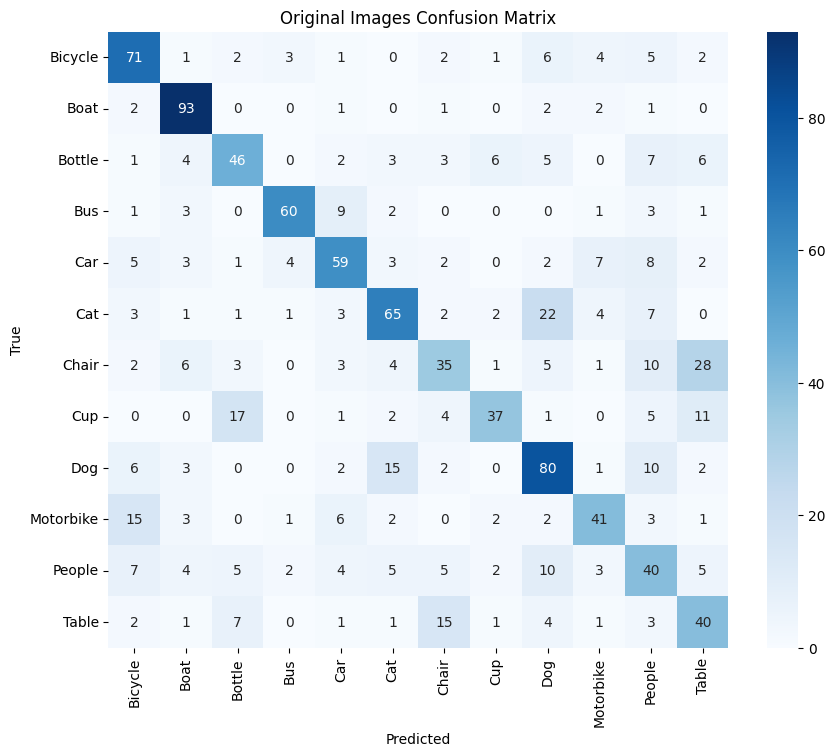


--- Enhanced Images ---
Accuracy: 0.5113
              precision    recall  f1-score   support

     Bicycle       0.42      0.69      0.52        98
        Boat       0.43      0.96      0.59       102
      Bottle       0.54      0.45      0.49        83
         Bus       0.80      0.59      0.68        80
         Car       0.69      0.39      0.49        96
         Cat       0.58      0.44      0.50       111
       Chair       0.43      0.43      0.43        98
         Cup       0.65      0.44      0.52        78
         Dog       0.56      0.54      0.55       121
   Motorbike       0.50      0.43      0.46        76
      People       0.61      0.21      0.31        92
       Table       0.43      0.51      0.47        76

    accuracy                           0.51      1111
   macro avg       0.55      0.51      0.50      1111
weighted avg       0.55      0.51      0.50      1111



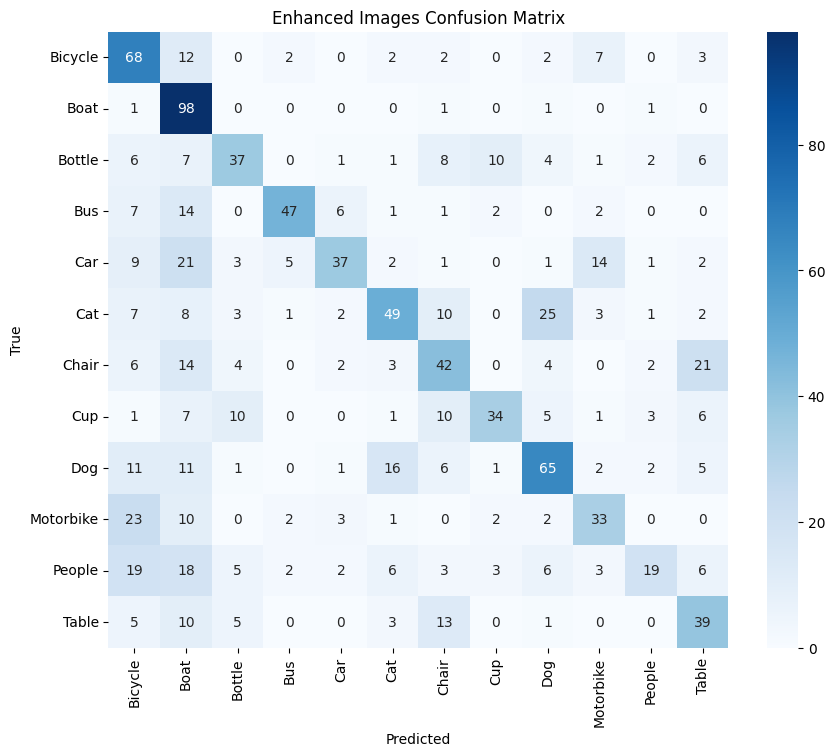


Accuracy Improvement (Enhanced vs Original): -0.0891


In [ ]:
# training and Validation
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

def train_model(model, loaders, epochs=10):
    best_acc = 0.0
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        model.train()
        running_loss, correct, total = 0, 0, 0

        for inputs, labels in loaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, loaders['val'])
        print(f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Save the best model based on validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            # torch.save(model.state_dict(), 'best_resnet18_2.pth')
            torch.save(model.state_dict(), '/content/drive/MyDrive/Dissertation/checkpoints/RestNet/best_resnet18_2.pth')
    print(f'Best Val Accuracy: {best_acc:.4f}')

train_model(model, orig_loaders, epochs=10)

# testing on Original vs Enhanced
def test_and_report(model, loader, label='Dataset'):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f'\n--- {label} ---')
    print(f'Accuracy: {acc:.4f}')
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f'{label} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return acc, all_preds, all_labels

# Load best checkpoint
model.load_state_dict(torch.load('/content/drive/MyDrive/Dissertation/checkpoints/RestNet/best_resnet18_2.pth'))

# Test on Original
orig_acc, orig_preds, orig_labels = test_and_report(model, orig_loaders['test'], 'Original Images')

# Test on Enhanced
enh_acc, enh_preds, enh_labels = test_and_report(model, enh_loaders['test'], 'Enhanced Images')

print(f'\nAccuracy Improvement (Enhanced vs Original): {enh_acc - orig_acc:.4f}')

#### Evaluating enhancement impact on Exdark Images

In [ ]:
# Ensure the test datasets have the same file ordering for comparison
orig_dataset = orig_loaders['test'].dataset
enh_dataset = enh_loaders['test'].dataset
assert [p[0].split('/')[-1] for p in orig_dataset.samples] == \
       [p[0].split('/')[-1] for p in enh_dataset.samples], \
       "Original and Enhanced test datasets must have identical image order for comparison."

# Map predictions to filenames
filenames = [p[0].split('/')[-1] for p in orig_dataset.samples]
comparison_stats = defaultdict(int)  # counters

# Compare results image by image
for fname, true, pred_orig, pred_enh in zip(filenames, orig_labels, orig_preds, enh_preds):
    if pred_orig == true and pred_enh == true:
        comparison_stats['correct_both'] += 1
    elif pred_orig != true and pred_enh != true:
        comparison_stats['wrong_both'] += 1
    elif pred_orig != true and pred_enh == true:
        comparison_stats['fixed_by_enhancement'] += 1
    elif pred_orig == true and pred_enh != true:
        comparison_stats['harmed_by_enhancement'] += 1

# Print summary
total = len(filenames)
print("\n--- Per-Image Comparison ---")
for k, v in comparison_stats.items():
    print(f"{k}: {v} ({v/total:.2%})")
print(f"Total test samples: {total}")
print(f"Net improvement (fixed - harmed): {comparison_stats['fixed_by_enhancement'] - comparison_stats['harmed_by_enhancement']}")


--- Per-Image Comparison ---
correct_both: 485 (43.65%)
harmed_by_enhancement: 182 (16.38%)
wrong_both: 361 (32.49%)
fixed_by_enhancement: 83 (7.47%)
Total test samples: 1111
Net improvement (fixed - harmed): -99


#### SCface

Sorting surveillance images by subject and Distance to cameras where dist 1 reps 4.2m, 2 reps 2.6m, and 3 reps 1.0m.

In [ ]:
# Paths
mugshot_path = "/content/drive/MyDrive/Dissertation/data/SCface_database/mugshot_frontal_original_all"
surveillance_path = "/content/drive/MyDrive/Dissertation/data/SCface_database/surveillance_cameras_all"
arranged_path = "/content/drive/MyDrive/Dissertation/data/SCface_database_arranged2"

gallery_path = os.path.join(arranged_path, "SCface_gallery")
probe_base = os.path.join(arranged_path, "SCface_probe")

# Create directories
os.makedirs(gallery_path, exist_ok=True)
for d in [1, 2, 3]:
    os.makedirs(os.path.join(probe_base, f"probe_distance{d}"), exist_ok=True)

# --- Step 1: Gallery (mugshots) ---
mugshot_files = [f for f in sorted(os.listdir(mugshot_path))
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

for fname in mugshot_files:
    sid = fname.split('_')[0]  # e.g., "001"
    subj_dir = os.path.join(gallery_path, f"s{sid}")
    os.makedirs(subj_dir, exist_ok=True)
    shutil.copy(os.path.join(mugshot_path, fname), os.path.join(subj_dir, fname))

print(f"✅ Copied {len(mugshot_files)} mugshots into gallery.")

# --- Step 2: Probe (surveillance) ---
surv_files = [f for f in sorted(os.listdir(surveillance_path))
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

counts = {1: 0, 2: 0, 3: 0, "unknown": 0}

for fname in surv_files:
    parts = Path(fname).stem.split('_')  # e.g., ['001', 'cam1', '1']
    if len(parts) != 3:
        counts["unknown"] += 1
        continue

    sid, cam, dist = parts
    try:
        dist = int(dist)
    except ValueError:
        counts["unknown"] += 1
        continue

    subj_dir = os.path.join(probe_base, f"probe_distance{dist}", f"s{sid}")
    os.makedirs(subj_dir, exist_ok=True)
    shutil.copy(os.path.join(surveillance_path, fname), os.path.join(subj_dir, fname))
    counts[dist] += 1

print("✅ Probe set created.")
print(f"Distance 1: {counts[1]} images")
print(f"Distance 2: {counts[2]} images")
print(f"Distance 3: {counts[3]} images")
print(f"Unknown format: {counts['unknown']} images")

✅ Copied 130 mugshots into gallery.
✅ Probe set created.
Distance 1: 910 images
Distance 2: 910 images
Distance 3: 910 images
Unknown format: 130 images


#### Enhancing SCface images by subject and distance.

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import os

# ==== Paths ====
probe_base = "/content/drive/MyDrive/Dissertation/data/SCface_database_arranged2/SCface_probe"
enhanced_base = "/content/drive/MyDrive/Dissertation/data/SCface_database_arranged2/SCface_probe_enhanced"
os.makedirs(enhanced_base, exist_ok=True)

# ==== Device ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Load Trained Generator ====
generator = UNetGenerator().to(device)
checkpoint_path = "/content/drive/MyDrive/Dissertation/checkpoints/gan2/gan_epoch_60.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint["generator_state_dict"])
generator.eval()
print("✅ Loaded trained GAN generator.")

# ==== Transforms ====
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

inv_normalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)

# ==== Enhancement Loop ====
for dist in [1, 2, 3]:
    probe_dist_dir = os.path.join(probe_base, f"probe_distance{dist}")
    enhanced_dist_dir = os.path.join(enhanced_base, f"probe_distance{dist}")
    os.makedirs(enhanced_dist_dir, exist_ok=True)

    for subject in sorted(os.listdir(probe_dist_dir)):
        subject_path = os.path.join(probe_dist_dir, subject)
        if not os.path.isdir(subject_path):
            continue

        enhanced_subject_path = os.path.join(enhanced_dist_dir, subject)
        os.makedirs(enhanced_subject_path, exist_ok=True)

        for img_name in sorted(os.listdir(subject_path)):
            if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
                continue

            img_path = os.path.join(subject_path, img_name)
            img = Image.open(img_path).convert("RGB")

            # Transform
            img_tensor = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                enhanced_tensor = generator(img_tensor)

            # Inverse normalization
            enhanced_tensor = inv_normalize(enhanced_tensor.squeeze(0).cpu()).clamp(0, 1)
            enhanced_img = transforms.ToPILImage()(enhanced_tensor)

            # Save enhanced image
            enhanced_img.save(os.path.join(enhanced_subject_path, img_name))

    print(f"✅ Enhanced images saved for probe_distance{dist}")

print("🎯 All probe distances enhanced and saved.")


✅ Loaded trained GAN generator.
✅ Enhanced images saved for probe_distance1
✅ Enhanced images saved for probe_distance2
✅ Enhanced images saved for probe_distance3
🎯 All probe distances enhanced and saved.


#### Evaluating enhancement on SCface data using pretrained vggface2.

In [ ]:
# !pip install facenet_pytorch

In [ ]:
# Downgrade pytorch to avoid Error: module 'torch' has no attribute 'unit64'
# !pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# Paths
base_path = "/content/drive/MyDrive/Dissertation/data/SCface_database_arranged2"
gallery_path = os.path.join(base_path, "SCface_gallery")
probe_path = os.path.join(base_path, "SCface_probe")
probe_enhanced_path = os.path.join(base_path, "SCface_probe_enhanced")

# Model
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Transform
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Required by InceptionResnetV1
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# get embedding
def get_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(img_tensor)
    return embedding.cpu().numpy()

# Load gallery embeddings
gallery_embeddings = {}
gallery_labels = {}

for subject in sorted(os.listdir(gallery_path)):
    subj_folder = os.path.join(gallery_path, subject)
    if not os.path.isdir(subj_folder):
        continue

    for img_file in os.listdir(subj_folder):
        img_path = os.path.join(subj_folder, img_file)
        emb = get_embedding(img_path)
        gallery_embeddings[subject] = emb
        gallery_labels[subject] = subject  # e.g., s001

print(f"✅ Loaded {len(gallery_embeddings)} gallery embeddings.")

# function to evaluate a probe set
def evaluate_probe(probe_base_path):
     """Evaluates face recognition accuracy for different probe distances.

    Calculates the top-1 accuracy by comparing probe image embeddings to
    gallery embeddings.

    Returns a dictionary where keys are distance names (e.g., 'distance1')
              and values are the calculated accuracies for that distance.
    """
    results = {}
    for dist in [1, 2, 3]:
        probe_dist_path = os.path.join(probe_base_path, f"probe_distance{dist}")
        correct = 0
        total = 0

        for subject in sorted(os.listdir(probe_dist_path)):
            subj_folder = os.path.join(probe_dist_path, subject)
            if not os.path.isdir(subj_folder):
                continue

            for img_file in os.listdir(subj_folder):
                img_path = os.path.join(subj_folder, img_file)
                probe_emb = get_embedding(img_path)

                # Compare to all gallery embeddings
                sims = {subj: cosine_similarity(probe_emb, emb)[0][0]
                        for subj, emb in gallery_embeddings.items()}

                # Predicted label = gallery subject with highest similarity
                pred_label = max(sims, key=sims.get)
                if pred_label == subject:
                    correct += 1
                total += 1

        acc = correct / total if total > 0 else 0
        results[f"distance{dist}"] = acc
    return results

# 3. Evaluate Original & Enhanced
original_results = evaluate_probe(probe_path)
enhanced_results = evaluate_probe(probe_enhanced_path)

# results
print("📊 Verification Accuracy (Top-1)")
for dist in [1, 2, 3]:
    print(f"Distance {dist} | Original: {original_results[f'distance{dist}']*100:.2f}% "
          f"| Enhanced: {enhanced_results[f'distance{dist}']*100:.2f}%")


✅ Loaded 130 gallery embeddings.
📊 Verification Accuracy (Top-1)
Distance 1 | Original: 6.15% | Enhanced: 3.96%
Distance 2 | Original: 10.00% | Enhanced: 5.93%
Distance 3 | Original: 9.23% | Enhanced: 5.38%


Visualizing comaparable metrics of the 2 experiments

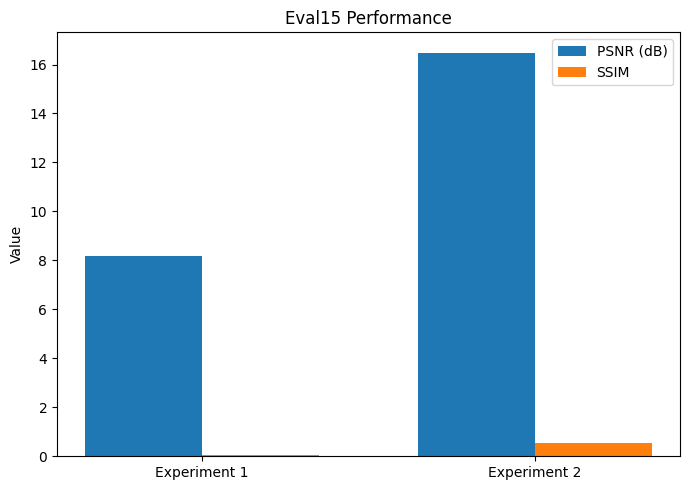

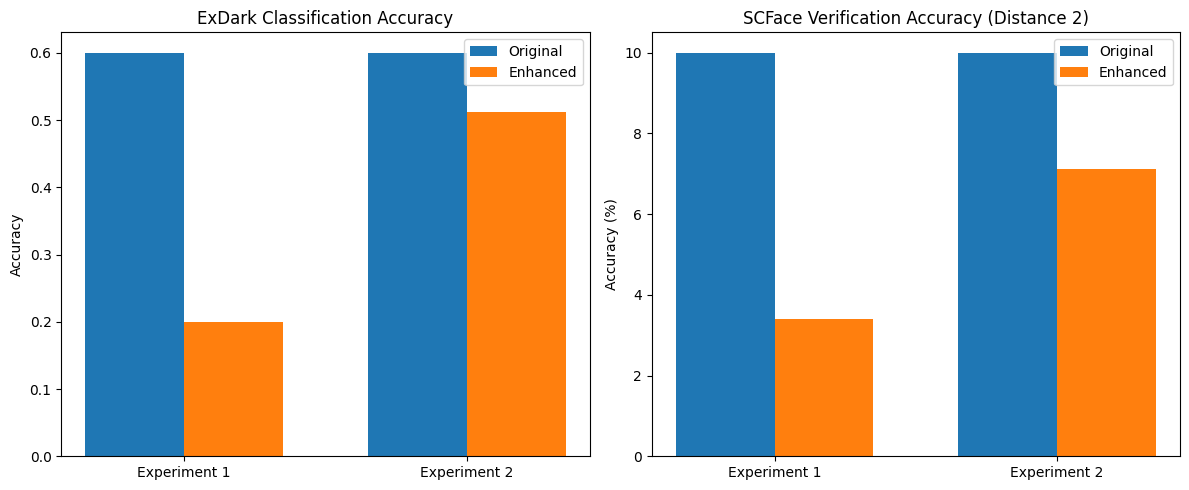

In [ ]:
experiments = ["Experiment 1", "Experiment 2"]

# Eval15 results
psnr = [8.19, 16.49]
ssim = [0.071, 0.557]

# ExDark recognition accuracy (original vs enhanced)
exdark_original = [0.6004, 0.6004]  # same baseline
exdark_enhanced = [0.2000, 0.5113]

# SCFace Distance 2 (original vs enhanced)
scface_original = [10.00, 10.00]
scface_enhanced = [3.41, 7.12]

# Eval15 PSNR/SSIM
fig, ax1 = plt.subplots(figsize=(7,5))
bar_width = 0.35
x = np.arange(len(experiments))

ax1.bar(x - bar_width/2, psnr, width=bar_width, label="PSNR (dB)")
ax1.bar(x + bar_width/2, ssim, width=bar_width, label="SSIM")

ax1.set_ylabel("Value")
ax1.set_title("Eval15 Performance")
ax1.set_xticks(x)
ax1.set_xticklabels(experiments)
ax1.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Dissertation/Report/Performance_on_Eval15.jpg")
# plt.show()

# ExDark & SCFace comparison
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=False)

# # ExDark
bar_width = 0.35
x = np.arange(len(experiments))
ax[0].bar(x - bar_width/2, exdark_original, width=bar_width, label="Original")
ax[0].bar(x + bar_width/2, exdark_enhanced, width=bar_width, label="Enhanced")
ax[0].set_title("ExDark Classification Accuracy")
ax[0].set_xticks(x)
ax[0].set_xticklabels(experiments)
ax[0].set_ylabel("Accuracy")
ax[0].legend()

# SCFace (Distance 2 as example)
ax[1].bar(x - bar_width/2, scface_original, width=bar_width, label="Original")
ax[1].bar(x + bar_width/2, scface_enhanced, width=bar_width, label="Enhanced")
ax[1].set_title("SCFace Verification Accuracy (Distance 2)")
ax[1].set_xticks(x)
ax[1].set_xticklabels(experiments)
ax[1].set_ylabel("Accuracy (%)")
ax[1].legend()

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Dissertation/Report/Performance_on_ExDark_and_Scface.jpg")
# plt.show()

### Side by side visual comparison

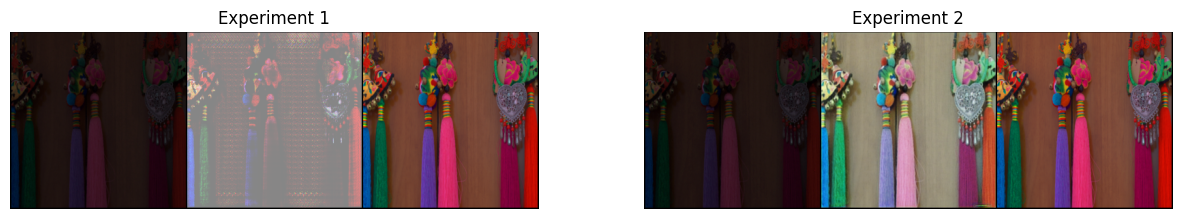

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_path1 = "/content/drive/MyDrive/Dissertation/evaluation/enhancement_per_epoch/epoch_60_eval15_sample_4.png"
img_path2 = "/content/drive/MyDrive/Dissertation/evaluation2/enhancement_per_epoch/epoch_69_eval15_sample_4.png"

img1 = cv2.imread(img_path1)
img2 = cv2.imread(img_path2)

# BGR to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(15, 12))

axs[0].imshow(img1)
axs[0].set_title("Experiment 1")
axs[0].axis("off")

axs[1].imshow(img2)
axs[1].set_title("Experiment 2")
axs[1].axis("off")

# Save the combined plot
plt.savefig("/content/drive/MyDrive/Dissertation/Report/plots/eval_15_visual_comparison.png", bbox_inches="tight")
# plt.close()

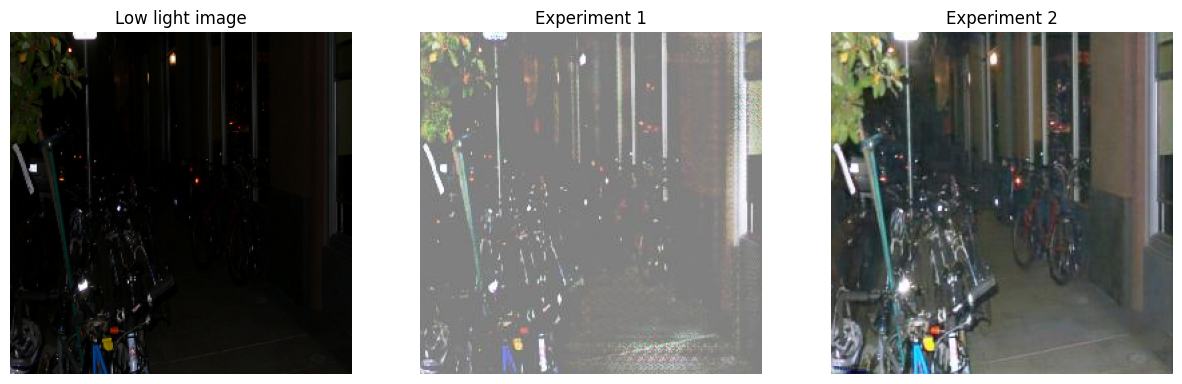

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_path1 = "/content/drive/MyDrive/Dissertation/data/ExDark/Bicycle/2015_00004.jpg"
img_path2 = "/content/drive/MyDrive/Dissertation/data/ExDark_enhanced/Bicycle/2015_00004.jpg"
img_path3 = "/content/drive/MyDrive/Dissertation/data/ExDark_enhanced2/Bicycle/2015_00004.jpg"

img1 = cv2.imread(img_path1)
img2 = cv2.imread(img_path2)
img3 = cv2.imread(img_path3)

# BGR to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# Resize img1 to 256x256 for visual comparison
img1_resized = cv2.resize(img1, (256, 256))

fig, axs = plt.subplots(1, 3, figsize=(15, 12))

axs[0].imshow(img1_resized)
axs[0].set_title("Low light image")
axs[0].axis("off")

axs[1].imshow(img2)
axs[1].set_title("Experiment 1")
axs[1].axis("off")

axs[2].imshow(img3)
axs[2].set_title("Experiment 2")
axs[2].axis("off")

# Save the combined plot
plt.savefig("/content/drive/MyDrive/Dissertation/Report/plots/ExDark_visual_comparison.png", bbox_inches="tight")
# plt.close()

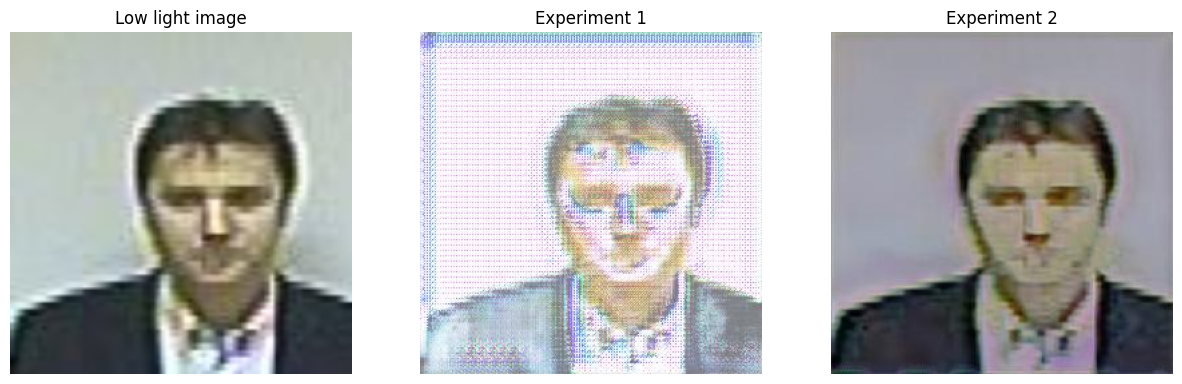

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_path1 = "/content/drive/MyDrive/Dissertation/data/SCface_database/surveillance_cameras_all/001_cam1_1.jpg"
img_path2 = "/content/drive/MyDrive/Dissertation/data/SCface_database_arranged/SCface_probe_enhanced/probe_distance1/s001/001_cam1_1.jpg"
img_path3 = "/content/drive/MyDrive/Dissertation/data/SCface_database_arranged2/SCface_probe_enhanced/probe_distance1/s001/001_cam1_1.jpg"

img1 = cv2.imread(img_path1)
img2 = cv2.imread(img_path2)
img3 = cv2.imread(img_path3)

# BGR to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# Resize img1 to 256x256 for visual comparison
img1_resized = cv2.resize(img1, (256, 256))

fig, axs = plt.subplots(1, 3, figsize=(15, 12))

axs[0].imshow(img1_resized)
axs[0].set_title("Low light image")
axs[0].axis("off")

axs[1].imshow(img2)
axs[1].set_title("Experiment 1")
axs[1].axis("off")

axs[2].imshow(img3)
axs[2].set_title("Experiment 2")
axs[2].axis("off")

# Save the combined plot
plt.savefig("/content/drive/MyDrive/Dissertation/Report/plots/SCface_visual_comparison.png", bbox_inches="tight")
# plt.close()

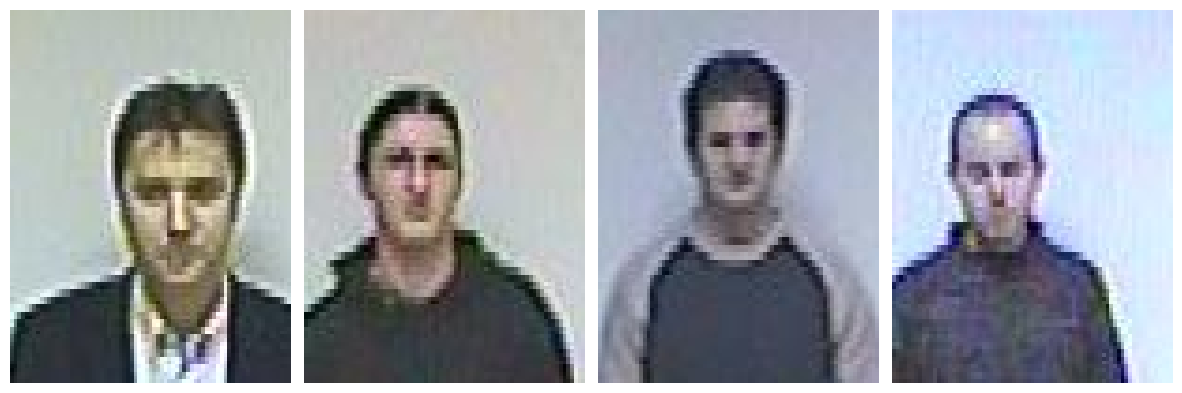

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_path1 = "/content/drive/MyDrive/Dissertation/data/SCface_database/surveillance_cameras_all/001_cam1_1.jpg"
img_path2 = "/content/drive/MyDrive/Dissertation/data/SCface_database/surveillance_cameras_all/002_cam2_1.jpg"
img_path3 = "/content/drive/MyDrive/Dissertation/data/SCface_database/surveillance_cameras_all/003_cam3_1.jpg"
img_path4 = "/content/drive/MyDrive/Dissertation/data/SCface_database/surveillance_cameras_all/004_cam4_1.jpg"
# img_path4 = "/content/drive/MyDrive/Dissertation/data/LOL_dataset/our485/high/107.png"
# img_path5 = "/content/drive/MyDrive/Dissertation/data/ExDark/Bus/2015_01879.jpg"

img1 = cv2.imread(img_path1)
img2 = cv2.imread(img_path2)
img3 = cv2.imread(img_path3)
img4 = cv2.imread(img_path4)

# BGR to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

# Resize img1 to 256x256 for visual comparison
img1_resized = cv2.resize(img1, (256, 256))

fig, axs = plt.subplots(1, 4, figsize=(15, 12))

# axs[0].imshow(img1_resized)
axs[0].imshow(img1)
# axs[0].set_title("Low light image")
axs[0].axis("off")

axs[1].imshow(img2)
# axs[1].set_title("Experiment 1")
axs[1].axis("off")

axs[2].imshow(img3)
# axs[2].set_title("Experiment 2")
axs[2].axis("off")

axs[3].imshow(img4)
# axs[3].set_title("Experiment 2")
axs[3].axis("off")

plt.subplots_adjust(wspace=0.05, hspace=0.05) # Reduce space

# Save the combined plot
plt.savefig("/content/drive/MyDrive/Dissertation/Report/plots/scface_samples.png", bbox_inches="tight")
# plt.close()